# NEW BUILD of transit fitting pipeline

In [1]:
# import relevant modules
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import scipy.signal as sig
from   scipy import stats
from   scipy import fftpack
import astropy
from   astropy.io import fits as pyfits

import csv
import sys
import os
import imp
from   timeit import default_timer as timer
import warnings
import progressbar

import lightkurve as lk
import exoplanet as exo
import theano.tensor as T
import pymc3 as pm
import corner

sys.path.append('/Users/research/Desktop/dinosaur/archeopteryx/')
import my_functions as fxns
imp.reload(fxns)

# define constants
pi = np.pi

RJRE = 10.973      # (Rjup/Rearth)
RSRE = 109.2       # (Rsun/Rearth)
RSRJ = RSRE/RJRE   # (Rsun/Rjup)

MJME = 317.828     # (Mjup/Mearth)
MSME = 332948.6    # (Msun/Mearth)
MSMJ = MSME/MJME   # (Msun/Mjup)

RSAU = 0.00465     # solar radius in AU

LCIT = 29.4244     # long cadence integration time (min)
SCIT = 58.84876    # short cadence integration time (sec)

# flush buffer to avoid mixed outputs from progressbar
sys.stdout.flush()

# turn off FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# start program timer
global_start_time = timer()

# Manually set global parameters

In [2]:
# TARGET and CSV_FILE
TARGET   = 'K00116'
CSV_FILE = '/Users/research/Desktop/dinosaur/archeopteryx/catalogues/pure_cks4.csv'

# Which QUARTERS to use
QSTART = 1                  # first quarter to search
QEND   = 17                 # last quarter to search (must be a contigous block)
NQ     = QEND-QSTART+1      # number of quarters searched

# directory in which to place MAST downloads
DOWNLOAD_DIR = '/Users/research/Desktop/dinosaur/archeopteryx/MAST_downloads/'

# Read in data from Kepler/Gaia

In [3]:
# READ IN THE DATA FROM CSV FILE
print('reading in data from csv file')

# make a target name lightkurve and MAST can understand
MAST_TARGET = 'KOI-'+ str(int(TARGET[1:]))

# read in a csv file containing info on targets
csv_keys, csv_values = fxns.read_csv_file(CSV_FILE)

# put these csv data into a dictionary
target_dict = {}
for k in csv_keys: 
    target_dict[k] = fxns.get_csv_data(k,csv_keys,csv_values)

# pull relevant quantities and establish GLOBAL variables
use = np.array(target_dict['id_starname']) == TARGET

NPL    = np.array(target_dict['koi_count'], dtype='int')[use]
RSTAR  = np.array(target_dict['iso_srad'],  dtype='float')[use]
MSTAR  = np.array(target_dict['iso_smass'], dtype='float')[use]

PERIODS = np.array(target_dict['koi_period'], dtype='float')[use]
EPOCHS  = np.array(target_dict['koi_time0'],  dtype='float')[use] - 2454833.0  # BKJD = BJD - 2454833
RADII   = np.array(target_dict['koi_prad'], dtype='float')[use]
DURS    = np.array(target_dict['koi_duration'], dtype='float')[use]/24         # [hrs] --> [days]

# do some consistency checks
if all(n == NPL[0] for n in NPL): NPL = NPL[0]
else: raise ValueError('There are inconsistencies with NPL in the csv input file')

if all(r == RSTAR[0] for r in RSTAR): RSTAR = RSTAR[0]
else: raise ValueError('There are inconsistencies with RSTAR in the csv input file')

if all(m == MSTAR[0] for m in MSTAR): MSTAR = MSTAR[0]
else: raise ValueError('There are inconsistencies with MSTAR in the csv input file')

# initialize with SOLAR limb darkening coefficients from EXOFAST
U1 = 0.39940842
U2 = 0.26477268
UCOEFFS = [U1, U2]

# put epochs in range (0,period)
for npl in range(NPL):
    EPOCHS[npl] = EPOCHS[npl] % PERIODS[npl]
    
# convert radii to units of STELLAR radius (ie rp/Rstar)
RADII = RADII / RSRE * RSTAR

reading in data from csv file


# Initialize Planet objects

In [4]:
# initialize Planet objects
print('initializing %d planet objects' %NPL)

imp.reload(fxns)

planets = []
for npl in range(NPL):
    p = fxns.Planet()
    
    # put in some basic transit parameters
    p.epoch    = EPOCHS[npl]
    p.period   = PERIODS[npl]
    p.radius   = RADII[npl]
    p.depth    = RADII[npl]**2
    p.duration = DURS[npl]
    p.impact   = 0.25
    p.esinw    = np.sqrt(0.0355)*np.random.randn()
    p.ecosw    = np.sqrt(0.0355)*np.random.randn()
    
    # list of ttv parameters - [Amp, Pttv, phi, Q0, Q1, Q2, Q3]
    p.pttv = np.array([1e-5, 512., pi/2, 1e-5, 1e-5, 1e-5, 1e-5])
    
    # estimate transit times from linear ephemeris
    p.tts = np.arange(p.epoch, 1600., p.period)
    
    # make transit indexes
    p.index = np.array(np.round((p.tts-p.epoch)/p.period),dtype='int')
    
    # update index and epoch to be centered on dataset
    p.index -= int(np.median(p.index))
    p.epoch = p.tts[p.index==0][0]
        
    planets.append(p)


# put planets in order by period
order = np.argsort(PERIODS)

sorted_planets = []
for npl in range(NPL):
    sorted_planets.append(planets[order[npl]])

planets = np.copy(sorted_planets)

initializing 4 planet objects


# Download and detrend lightcurves from MAST

In [5]:
# download long cadence data
print('downloading long cadence data from MAST')
lc_rawdata_list = fxns.download_lkf(MAST_TARGET, qstart=QSTART, qend=QEND, download_dir=DOWNLOAD_DIR)

# clean up LC data
QLIST = []
for q in range(NQ):
    if lc_rawdata_list[q] != None:
        QLIST.append(q)
        
NQ = len(QLIST) 
lc_rawdata_list = list(filter(None,lc_rawdata_list))


# download short cadence data -- appending to a list avoids errors with files not closing properly
print('downloading short cadence data from MAST')

sc_rawdata_list = []
sc_rawdata_list.append(lk.search_lightcurvefile(MAST_TARGET, cadence='short', mission='Kepler')\
                       .download_all(download_dir=DOWNLOAD_DIR))
sc_rawdata_list = sc_rawdata_list[0]

downloading long cadence data from MAST
downloading short cadence data from MAST


In [6]:
# make masks of expected transit times
print('making transit masks')

lc_mask_list = []
for q in range(NQ):
    qtime = lc_rawdata_list[q].PDCSAP_FLUX.time
    qmask = np.zeros_like(qtime, dtype='bool')
    
    for npl in range(NPL):
        qmask += fxns.make_transitmask(qtime, planets[npl].tts, planets[npl].duration, masksize=1.5)
        
    lc_mask_list.append(qmask)
    
sc_mask_list = []
for i in range(len(sc_rawdata_list)):
    stime = sc_rawdata_list[i].PDCSAP_FLUX.time
    smask = np.zeros_like(stime, dtype='bool')
    
    for npl in range(NPL):
        smask += fxns.make_transitmask(stime, planets[npl].tts, planets[npl].duration, masksize=1.5)
        
    sc_mask_list.append(smask)

making transit masks


detrending long cadence data
detrending short cadence data


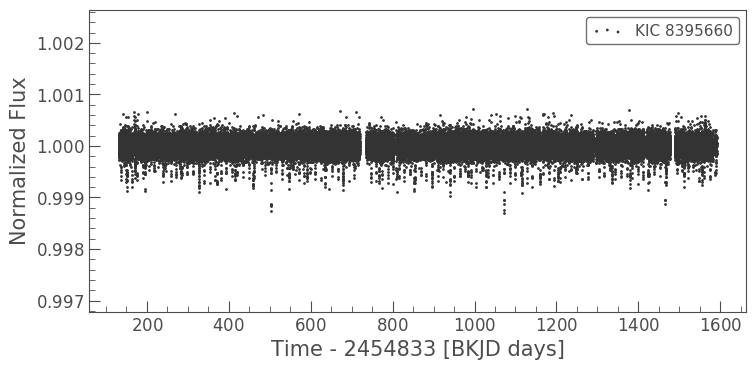

In [7]:
# detrend long cadence data
print('detrending long cadence data')
lc_pdcsap = fxns.detrend_and_join(lc_rawdata_list, polyorder=2, masklist=lc_mask_list)
lc_pdcsap.scatter()

lc_time  = lc_pdcsap.time
lc_flux  = lc_pdcsap.flux
lc_error = lc_pdcsap.flux_err
lc_cadno = lc_pdcsap.cadenceno


# detrend short cadence data (don't plot with lk.scatter -- there's too much data!)
print('detrending short cadence data')
sc_pdcsap = fxns.detrend_and_join(sc_rawdata_list, polyorder=2, window_length=3001, break_tolerance=750, \
                                   masklist=sc_mask_list)

sc_time  = sc_pdcsap.time
sc_flux  = sc_pdcsap.flux
sc_error = sc_pdcsap.flux_err
sc_cadno = sc_pdcsap.cadenceno


In [8]:
# remake individual masks for where each planet transits
print('making new transit masks')

lc_mask = np.zeros((NPL,len(lc_time)),dtype='bool')
sc_mask = np.zeros((NPL,len(sc_time)),dtype='bool')

for npl, p in enumerate(planets):
    lc_mask[npl] = fxns.make_transitmask(lc_time, p.tts, p.duration, masksize=1.5)
    sc_mask[npl] = fxns.make_transitmask(sc_time, p.tts, p.duration, masksize=1.5)

making new transit masks


# Cut stamps around each transit

In [9]:
# cut stamps
print('cutting stamps')

for npl, p in enumerate(planets):
    print('\nPLANET %d, P = %.2f' %(npl+1,p.period))
    # make some masks
    thisplanet  = np.arange(NPL) == npl
    otherplanet = np.arange(NPL) != npl
    
    lc_selfmask = np.squeeze(lc_mask[thisplanet])
    sc_selfmask = np.squeeze(sc_mask[thisplanet])
    
    lc_siblingmask = np.sum(lc_mask[otherplanet],axis=0,dtype='bool')
    sc_siblingmask = np.sum(sc_mask[otherplanet],axis=0,dtype='bool')
        
    # cut long cadence stamps
    lc_time_stamps  = fxns.cut_stamps(p, lc_time, lc_time, dtype='float64')
    lc_flux_stamps  = fxns.cut_stamps(p, lc_time, lc_flux, dtype='float64')
    lc_error_stamps = fxns.cut_stamps(p, lc_time, lc_error, dtype='float64')
    lc_mask_stamps  = fxns.cut_stamps(p, lc_time, lc_siblingmask, dtype='bool')
    lc_cadno_stamps = fxns.cut_stamps(p, lc_time, lc_cadno, dtype='int64')
    
    # cut short cadence stamps
    sc_time_stamps  = fxns.cut_stamps(p, sc_time, sc_time, dtype='float64')
    sc_flux_stamps  = fxns.cut_stamps(p, sc_time, sc_flux, dtype='float64')
    sc_error_stamps = fxns.cut_stamps(p, sc_time, sc_error, dtype='float64')
    sc_mask_stamps  = fxns.cut_stamps(p, sc_time, sc_siblingmask, dtype='bool')
    sc_cadno_stamps = fxns.cut_stamps(p, sc_time, sc_cadno, dtype='int64')
    
    # combine SC and LC stamps
    p.time_stamps,  t_cadence = fxns.combine_stamps(sc_time_stamps,  lc_time_stamps)
    p.flux_stamps,  f_cadence = fxns.combine_stamps(sc_flux_stamps,  lc_flux_stamps)
    p.error_stamps, e_cadence = fxns.combine_stamps(sc_error_stamps, lc_error_stamps)
    p.mask_stamps,  m_cadence = fxns.combine_stamps(sc_mask_stamps,  lc_mask_stamps)
    p.cadno_stamps, c_cadence = fxns.combine_stamps(sc_cadno_stamps, lc_cadno_stamps)
    
    checkf = np.array_equal(t_cadence, f_cadence)
    checke = np.array_equal(t_cadence, e_cadence)
    checkm = np.array_equal(t_cadence, m_cadence)
    checkc = np.array_equal(t_cadence, c_cadence)
    
    if (checkf+checke+checkm+checkc) == False:
        raise ValueError('recovered stamp cadences do not all match')
    else:
        p.stamp_cadence = t_cadence

    # clean up the stamps
    p.mask_overlapping_transits()
    p.clip_outlier_cadences()
    p.flatten_stamps()
    p.calculate_stamp_coverage()    
    p.identify_good_transits(cover_fraction=0.7, chisq_sigma=20.0)

cutting stamps

PLANET 1, P = 6.16
0 out of 207 transits rejected with high chisq
11 out of 207 transits rejected with insufficient coverage

PLANET 2, P = 13.57
0 out of 92 transits rejected with high chisq
8 out of 92 transits rejected with insufficient coverage

PLANET 3, P = 23.98
0 out of 56 transits rejected with high chisq
11 out of 56 transits rejected with insufficient coverage

PLANET 4, P = 43.84
0 out of 28 transits rejected with high chisq
4 out of 28 transits rejected with insufficient coverage


LONG CADENCE TRANSITS


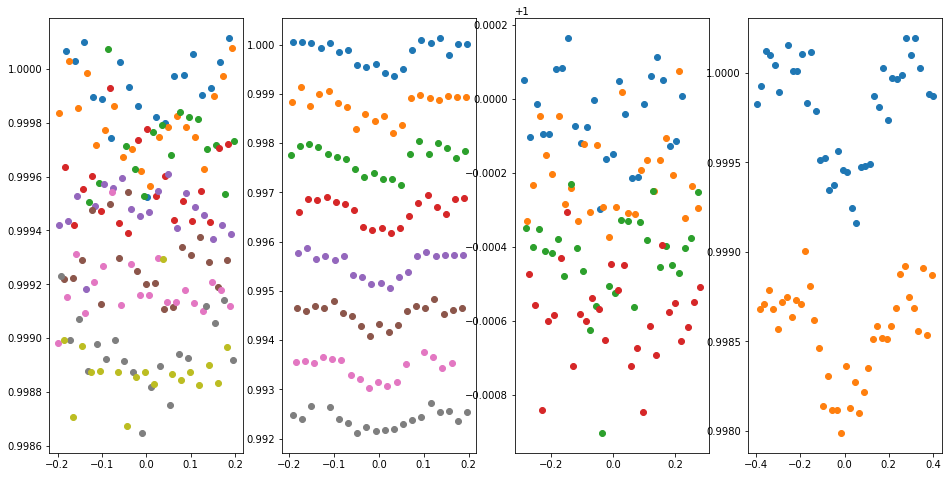

In [10]:
# display a few long cadence stamps
print('LONG CADENCE TRANSITS')
fig, axes = plt.subplots(1, NPL, figsize=(16,8))

for npl, p in enumerate(planets):
    lcts = p.grab_stamps('time', 'long')
    lcfs = p.grab_stamps('flux', 'long')
    
    tts = p.tts[p.quality*(p.stamp_cadence=='long')]
    
    ax = axes[npl]
    for i in range(np.min([9,len(lcts)])):
        ax.plot(lcts[i]-tts[i], lcfs[i]-p.depth*2*i, 'o')
    
plt.show()

SHORT CADENCE TRANSITS


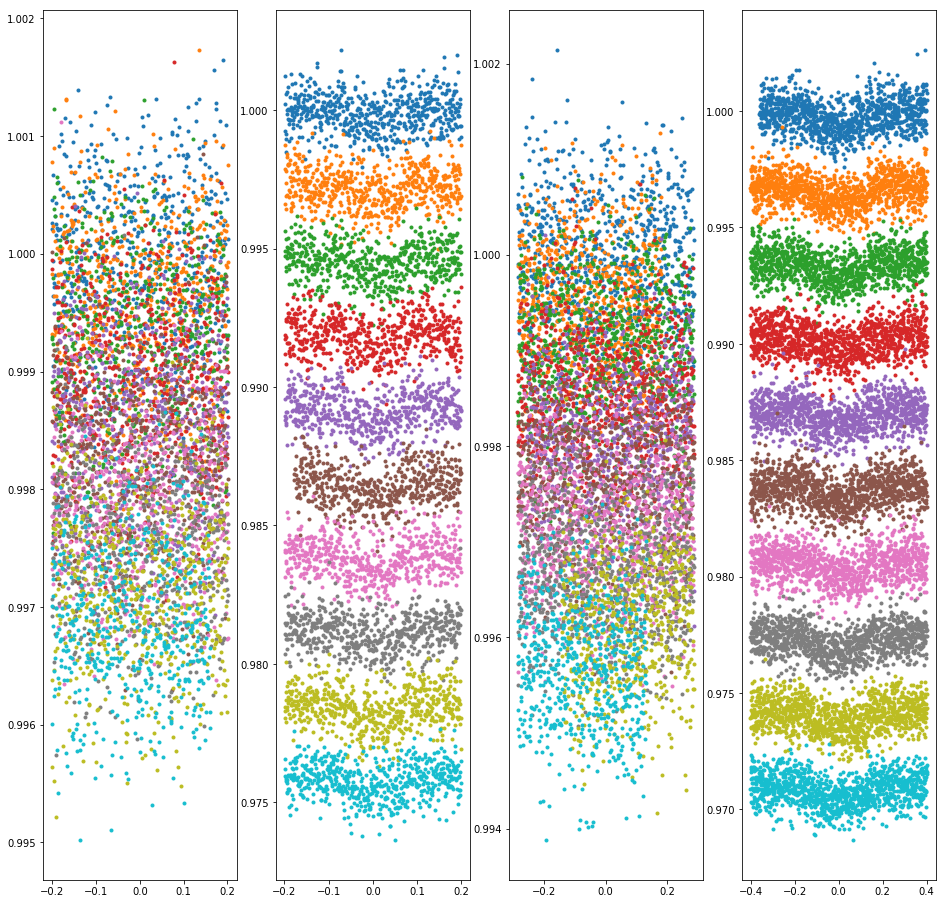

In [11]:
# display a few short cadence stamps
print('SHORT CADENCE TRANSITS')
fig, axes = plt.subplots(1, NPL, figsize=(16,16))

for npl, p in enumerate(planets):
    scts = p.grab_stamps('time', 'short')
    scfs = p.grab_stamps('flux', 'short')
    
    tts = p.tts[p.quality*(p.stamp_cadence=='short')]
    
    ax = axes[npl]
    for i in range(np.min([10,len(scts)])):
        ax.plot(scts[i]-tts[i], scfs[i]-p.depth*5*i, '.')
    
plt.show()

# Make ACF and pull out significant frequencies

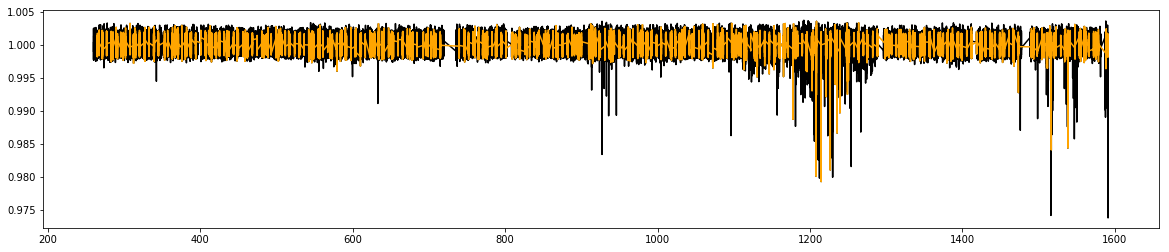

In [12]:
# make a mask where any planet transits
scm = sc_mask.sum(axis=0) > 0

# set Npts from 3 x maximum transit duration
durations = np.zeros(NPL)
for npl, p in enumerate(planets):
    durations[npl] = p.duration
Npts = int(3*durations.max()*24*3600/SCIT)

plt.figure(figsize=(20,4))
plt.plot(sc_time, sc_flux, 'k')
plt.plot(sc_time[scm], sc_flux[scm], 'orange')
plt.show()

In [13]:
def make_chunklist(time, flux, cadno, Npts, sigma_reject=5.0):
    '''
    time: out of transit time values
    flux: out of transit flux values
    cadno: out of transit cadence numbers
    Npts: number of points to use in each chunk; should be ~3x max transit duration
    sigma_reject: sigma threshold for rejection of noisy chunks (default=5.0)
    '''
    chunklist = []
    
    i = 0
    loop = True
    while(loop):
        # mark start and end cadence for this chunk
        cad_low  = cadno[i]
        cad_high = cad_low + Npts + 1

        use = (cadno >= cad_low)*(cadno < cad_high)

        # check if there are gaps
        index = cadno[use] - cad_low
        gaps  = np.hstack([1,index[1:]-index[:-1]])
        
        
        # make sure there are no consecutive missing cadences
        if gaps.max() <= 2:
            # pull time and flux chunks
            t_chunk = np.ones(Npts+1)*99      # use '99' to mark missing cadences
            f_chunk = np.ones(Npts+1)*99

            t_chunk[index] = time[use]
            f_chunk[index] = flux[use]

            # interpolate over missing cadences
            empty = t_chunk == 99

            t_chunk[empty] = np.interp(np.arange(Npts+1)[empty], index, t_chunk[~empty])
            f_chunk[empty] = np.interp(np.arange(Npts+1)[empty], index, f_chunk[~empty])

            # require at least 99% coverage
            if np.sum(empty)/Npts < 0.01:
                chunklist.append(f_chunk)

            i += Npts
            
        # if there are missing cadences, move forward past any gaps
        else:
            i += np.argmax(gaps>2)
        
        # finish the loop if there is no more unusued flux
        if i > (len(time)-Npts-1):
            loop = False
    
    
    # convert list to array
    chunklist = np.array(chunklist)
    
    
    # reject any chunks with unusually high medians or variability
    loop = True
    while(loop):
        mad_chunk = astropy.stats.mad_std(chunklist, axis=1)
        med_chunk = np.median(chunklist, axis=1)

        bad = np.abs(mad_chunk - np.median(mad_chunk))/astropy.stats.mad_std(mad_chunk) > sigma_reject
        bad += np.abs(med_chunk - np.median(med_chunk))/astropy.stats.mad_std(med_chunk) > sigma_reject

        chunklist = chunklist[~bad]

        if np.sum(bad) == 0:
            loop = False
            
            
    return chunklist

In [14]:
print('Modeling stellar variablity\n')

# cut "chunks" from the out-of-transit data
chunklist = make_chunklist(sc_time[~scm], sc_flux[~scm], sc_cadno[~scm], Npts)

Nsamples = chunklist.shape[0]

print('Number of samples =', Nsamples)
print('Points per sample =', Npts)

# generate the autocorrelation function
acor = np.zeros((Nsamples, 2*Npts+1))

for i in range(Nsamples):
    acor[i] = np.correlate(1-chunklist[i], 1-chunklist[i], mode='full')
    
acor = np.median(acor, axis=0)
acor = acor[Npts:]/acor[Npts]

xcor = np.arange(Npts+1)*SCIT/3600
wcor = np.ones(Npts+1)*astropy.stats.mad_std(acor[1:])

# pull off the zero-lag value
acor0 = acor[0]

xcor = xcor[1:]
acor = acor[1:]
wcor = wcor[1:]

Modeling stellar variablity

Number of samples = 850
Points per sample = 1177


In [15]:
# minimum and maximum testable time deltas
Tmin = xcor[1]-xcor[0]
Tmax = xcor.max()/2

N = Npts//2

# FFT convolved with a blackman windown (to reduce spectral leakage)
window = sig.blackman(Npts)

xf = np.linspace(0, 1/(2*Tmin), N)
yf = np.abs(fftpack.fft(window*acor)[:N])

# ignore the very low frequency signals
keep = xf > 3/Tmax

xf = xf[keep]
yf = yf[keep]


# smooth it
#for i in range(2):
#    yf = sig.convolve(yf, sig.boxcar(3), mode='same')

# make a copy
xf_all = xf.copy()
yf_all = yf.copy()

In [16]:
def lorentzian(theta, x):
    '''
    theta: array, [loc, scale, height, baseline]
    '''
    loc, scale, height, baseline = theta
    
    return height*stats.cauchy(loc=loc, scale=scale).pdf(x) + baseline

def residuals_for_lorentz(theta, x, y):
    return y - lorentzian(theta, x)

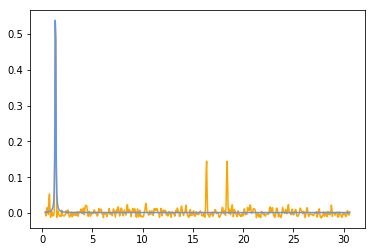

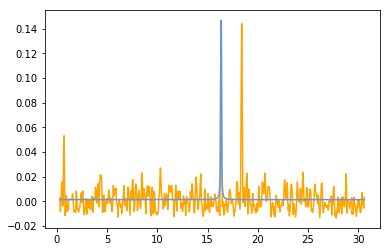

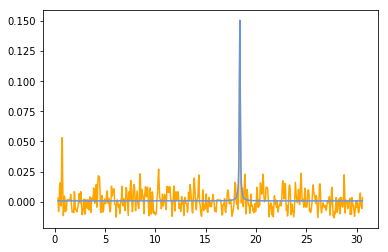

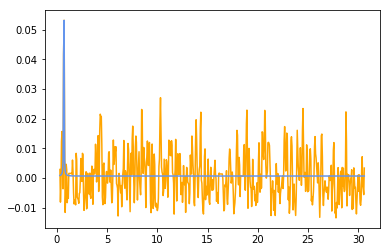

significant frequencies (min): [45.23  3.67  3.26 85.1 ]
2 low frequencies
2 high frequencies


In [17]:
xf = xf_all.copy()
yf = yf_all.copy() - np.median(yf_all)

freqs = []

loop = True
while loop:
    noise = astropy.stats.mad_std(yf)
    peakfreq = xf[np.argmax(yf)]
    
    if yf[xf==peakfreq]/noise > 5.0:
        theta_in = np.array([peakfreq, 1/Tmax, yf.max(), np.median(yf)])
        theta_out, success = op.leastsq(residuals_for_lorentz, theta_in, args=(xf, yf))
    
        plt.figure()
        plt.plot(xf, yf, color='orange')
        plt.plot(xf, lorentzian(theta_out, xf), color='cornflowerblue')
        plt.show()
        
        width = np.max(5*[theta_out[1], 3*(xf[1]-xf[0])])
        mask = np.abs(xf-theta_out[0])/width < 1
        
        yf[mask] = theta_out[3]
        
        freqs.append(theta_out[0])
        
    else:
        loop = False

        
freqs = np.array(freqs)

low_freqs  = freqs[60/freqs > LCIT]
high_freqs = freqs[60/freqs < LCIT]

print('significant frequencies (min):', (60/freqs).round(2))
print('%d low frequencies' %len(low_freqs))
print('%d high frequencies' %len(high_freqs))

# Fit a GP for the low-frequency terms of the ACF

In [35]:
with pm.Model() as model:
    # set up the kernel
    if len(low_freqs) == 0:
        print('No low-frequency signal...using Matern 3/2 kernel')
        logsig = pm.Normal('logsig', mu=0.0, sd=15.0)
        logrho = pm.Normal('logrho', mu=0.0, sd=15.0)
        
        kernel  = exo.gp.terms.Matern32Term(log_rho=logrho, log_sigma=logsig)
    
    else:
        logS1 = pm.Normal('logS1', mu=np.log(np.var(acor)), sd=15.0)
        logQ1 = pm.Normal('logQ1', mu=0.0, sd=15.0, testval=np.log(3))
        
        kernel = exo.gp.terms.SHOTerm(log_S0=logS1, log_w0=np.log(2*pi*low_freqs[0]), log_Q=logQ1)
        
        if len(low_freqs) == 1:
            print('One low-freqency signal found...using a single SHOTerm kernel')
            
        elif len(low_freqs) > 1:
            print('Multiple low-frequency signals found...using a double SHOTerm kernel')
    
            logS2 = pm.Normal('logS2', mu=np.log(np.var(acor)), sd=15.0)
            logQ2 = pm.Normal('logQ2', mu=0.0, sd=15.0, testval=np.log(3))
    
            kernel += exo.gp.terms.SHOTerm(log_S0=logS2, log_w0=np.log(2*pi*low_freqs[1]), log_Q=logQ2)    
    
    # set up the GP
    gp = exo.gp.GP(kernel, xcor, wcor**2)
    
    # add custom potential (log-prob fxn) with the GP likelihood
    pm.Potential('gp', gp.log_likelihood(acor))
    
    
    
    # now add in an exponential + cubic trend
    logAmp = pm.Normal('logAmp', mu=0.0, sd=15.0, testval=np.log(np.var(acor)))
    logtau = pm.Normal('logtau', mu=0.0, sd=15.0, testval=np.log(xcor.max()))

    Amp = pm.Deterministic('Amp', T.exp(logAmp))
    tau = pm.Deterministic('tau', T.exp(logtau))
        
    trend = Amp*T.exp(-xcor/tau)
        
    pm.Potential('obs', gp.log_likelihood(acor - trend))

Multiple low-frequency signals found...using a double SHOTerm kernel


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logtau, logAmp, logQ2, logS2, logQ1, logS1]
Sampling 2 chains: 100%|██████████| 8000/8000 [01:19<00:00, 100.19draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logS1,-19.572790,0.271310,0.005349,-20.110515,-19.060599,2517.544076,0.999921
logQ1,6.265970,0.816076,0.022705,4.855825,7.985519,1251.151712,1.001847
logS2,-10.660139,2.420260,0.088629,-14.207803,-6.344562,666.555079,1.001689
logQ2,-4.384469,1.265647,0.044940,-6.780601,-2.442568,722.056592,1.001451
logAmp,-4.312589,0.129757,0.002665,-4.558728,-4.041901,2490.766620,1.000476
logtau,-2.035724,0.199097,0.004078,-2.430059,-1.639184,2634.438532,0.999834
Amp,0.013511,0.001735,0.000035,0.010076,0.017065,2661.822940,1.000458
tau,0.133196,0.026750,0.000553,0.082369,0.183552,2618.862645,0.999885


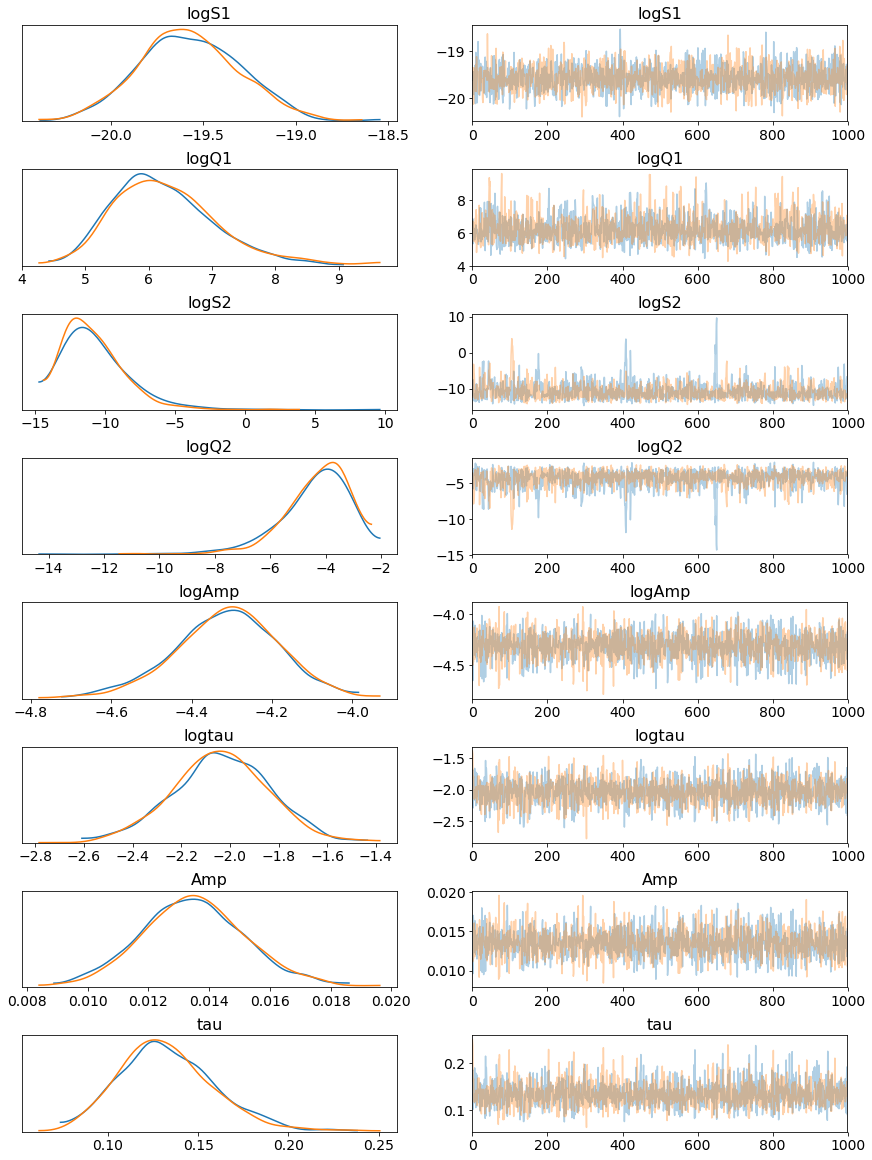

In [36]:
with model:
    trace = pm.sample(tune=3000, draws=1000, start=model.test_point, chains=2, \
                     step=exo.get_dense_nuts_step(target_accept=0.9))
    
pm.traceplot(trace)
pm.summary(trace)

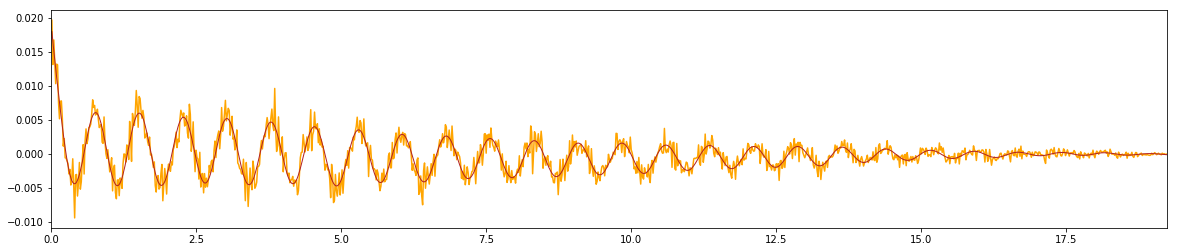

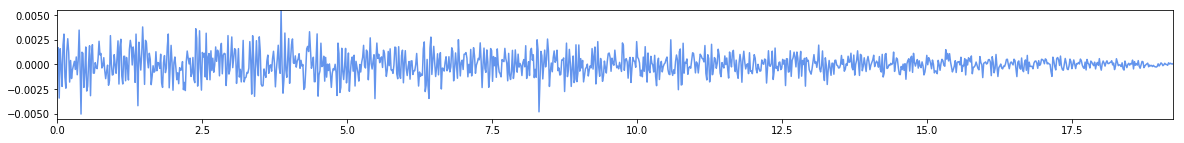

In [37]:
lowf_soln = {}

for v in trace.varnames:
    lowf_soln[v] = np.median(trace.get_values(v))
    
with model:
    acor_model, acor_model_var = exo.eval_in_model(gp.predict(xcor, return_var=True), lowf_soln)
    
    #c0, c1, c2, c3 = lowf_soln['c0'], lowf_soln['c1'], lowf_soln['c2'], lowf_soln['c3']
    Amp, tau = lowf_soln['Amp'], lowf_soln['tau']
    
    acor_model += Amp*np.exp(-xcor/tau) #+ c0+c1*xcor+c2*xcor**2+c3*xcor**3
    
    
    
rcor = acor - acor_model
    
plt.figure(figsize=(20,4))
plt.plot(xcor, acor, c='orange')
plt.plot(xcor, acor_model, c='firebrick', lw=1)
plt.xlim(0,xcor.max())
plt.show()

plt.figure(figsize=(20,2))
plt.plot(xcor, rcor, c='cornflowerblue')
plt.xlim(0,xcor.max())
plt.ylim(-0.0055, 0.0055)
plt.show()

# Let's try to get a better ACF model by fitting the residuals

In [38]:
with pm.Model() as model:
    # set up the kernel
    logS1 = pm.Normal('logS1', mu=0.0, sd=15.0, testval=np.log(np.var(rcor)))
    logQ1 = pm.Normal('logQ1', mu=0.0, sd=15.0, testval=np.log(3))
    
    kernel = exo.gp.terms.SHOTerm(log_S0=logS1, log_w0=np.log(2*pi*high_freqs[0]), log_Q=logQ1)
    
    if len(high_freqs) == 1:
        print('One high-freqency signal found...using a single SHOTerm kernel')
        
    elif len(high_freqs) > 1:
        print('Multiple high-freqency signals found...using a double SHOTerm kernel')
        
        logS2 = pm.Normal('logS2', mu=np.log(np.var(rcor)), sd=15.0)
        logQ2 = pm.Normal('logQ2', mu=0.0, sd=15.0, testval=np.log(3))
        
        kernel += exo.gp.terms.SHOTerm(log_S0=logS2, log_w0=np.log(2*pi*high_freqs[1]), log_Q=logQ2)
    
    # set up the GP
    gp = exo.gp.GP(kernel, xcor, wcor**2)
    
    # add custom potential (log-prob fxn) with the GP likelihood
    pm.Potential('gp', gp.log_likelihood(rcor))

Multiple high-freqency signals found...using a double SHOTerm kernel


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logQ2, logS2, logQ1, logS1]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:52<00:00, 152.13draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logS1,-26.677055,0.552028,0.014660,-27.741848,-25.569811,1395.199837,0.999637
logQ1,7.313153,1.189837,0.032351,5.239223,9.675857,1161.322373,0.999905
logS2,-26.444696,0.468879,0.009261,-27.311453,-25.495237,2077.056985,1.000931
logQ2,6.991818,1.136870,0.035658,5.072556,9.211894,1046.557869,1.000273


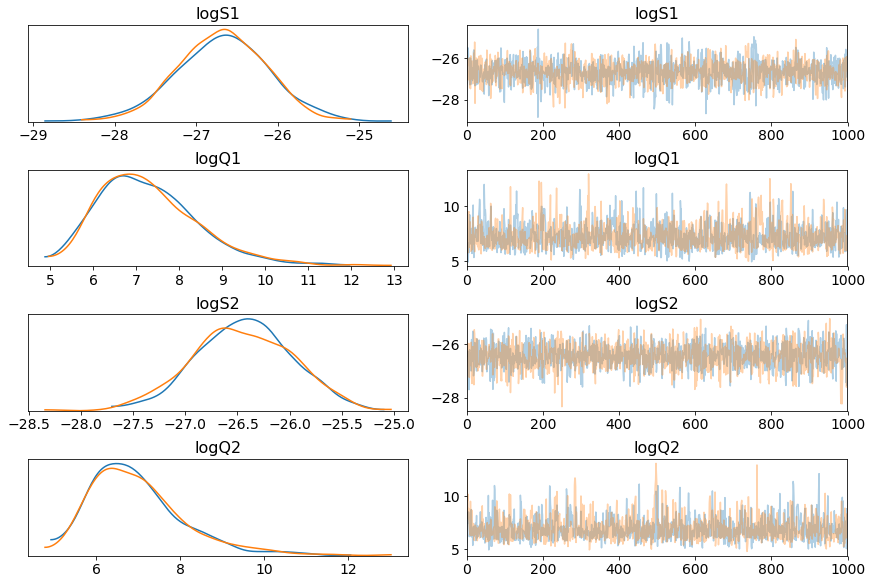

In [39]:
with model:
    trace = pm.sample(tune=3000, draws=1000, start=model.test_point, chains=2, \
                     step=exo.get_dense_nuts_step(target_accept=0.9))
    
pm.traceplot(trace)
pm.summary(trace)

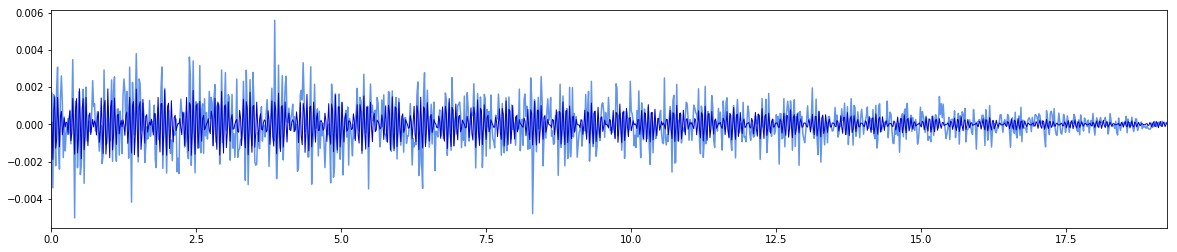

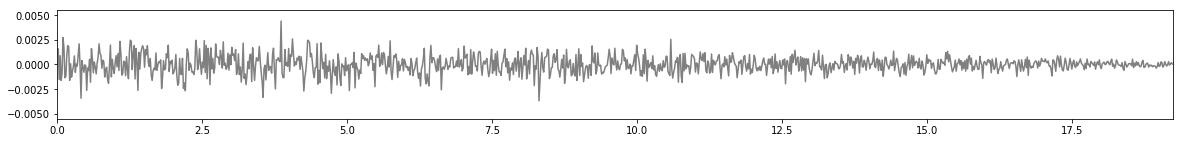

In [40]:
highf_soln = {}

for v in trace.varnames:
    highf_soln[v] = np.median(trace.get_values(v))
    
with model:
    rcor_model, rcor_model_var = exo.eval_in_model(gp.predict(xcor, return_var=True), highf_soln)
    
    
    
plt.figure(figsize=(20,4))
plt.plot(xcor, rcor, c='cornflowerblue')
plt.plot(xcor, rcor_model, c='mediumblue', lw=1)
plt.xlim(0,xcor.max())
plt.show()

plt.figure(figsize=(20,2))
plt.plot(xcor, rcor-rcor_model, c='grey')
plt.xlim(0,xcor.max())
plt.ylim(-0.0055, 0.0055)
plt.show()

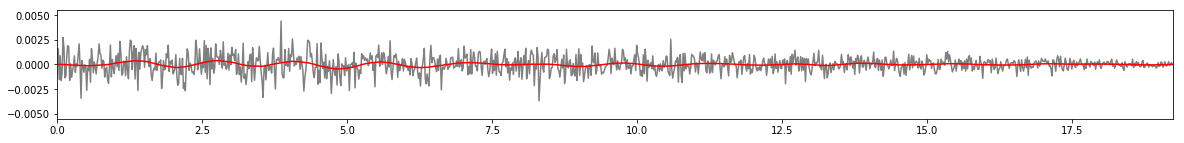

In [41]:
win = sig.boxcar(31)/31

smoothed_res = sig.convolve(rcor-rcor_model, win, mode='same')
smoothed_res = sig.convolve(smoothed_res, win, mode='same')

plt.figure(figsize=(20,2))
plt.plot(xcor, rcor-rcor_model, c='grey')
plt.plot(xcor, smoothed_res, c='red')
plt.xlim(0,xcor.max())
plt.ylim(-0.0055, 0.0055)
plt.show()

# Make the covariance matrix

In [ ]:
# make the covariance matrix
print('making covariance matrix')

# get size of longest stamp
stamplength = []
for npl, p in enumerate(planets):
    tstamps = p.grab_stamps('time')
    
    for ts in tstamps:
        stamplength.append(int(np.round((ts[-1]-ts[0])/(SCIT/3600/24))))
        
msl = np.max(stamplength) + 1

# estimate contribution from red and white noise
sigma_white = np.median(sc_error)
sigma_tot   = np.std(sc_flux[~scm])
sigma_red   = np.sqrt(sigma_tot**2 - sigma_white**2)

# here's the master covariance matrix
covmatrix = fxns.make_covariance_matrix(acor_model, msl, sigma_white, sigma_red, do_plots=True)

# now populate each planet object with its own inverse cocmatrix
for npl, p in enumerate(planets):
    N = len(p.tts)
    
    icov = []
    for i in range(N):
        if p.quality[i] == False:
            icov.append(None)
        else:
            cadence = p.stamp_cadence[i]
            tstamp  = p.time_stamps[i]
            estamp  = p.error_stamps[i]
            
            if cadence == 'short':
                x = np.array(np.round((tstamp-tstamp[0])/(SCIT/3600/24)),dtype='int')
                cm_here = covmatrix[x,:]
                cm_here = cm_here[:,x]
                icov.append(np.linalg.inv(cm_here))
            
            elif cadence == 'long':
                cm_here = np.diag(np.ones(len(estamp))*np.median(estamp)**2)
                icov.append(np.linalg.inv(cm_here))
                
    p.icov = icov

# Fit individual Keplerian models with zero eccentricity

In [ ]:
# Let's fit a Keplerian transit model
start = timer()

for npl, p in enumerate(planets):
    print('\n\nPLANET %d, P = %.2f' %(npl+1,p.period))
        
    # grab time, flux, and error
    data_time  = np.hstack(p.grab_stamps('time'))
    data_flux  = np.hstack(p.grab_stamps('flux'))
    data_error = np.hstack(p.grab_stamps('error'))
    
    
    # phase time for plotting purposes
    time_stamps = p.grab_stamps('time')
    t_phased = []
    
    for i, t0 in enumerate(p.tts[p.quality]):
        t_phased.append(time_stamps[i]-t0)
    
    t_phased = np.hstack(t_phased)
    t_plot = np.linspace(t_phased.min(), t_phased.max(), 1000)
    
    
    with pm.Model() as model:
        print('\nsetting up KEPLERIAN model')
               
        # stellar parameters (limb darkening using Kipping 2013)
        u = exo.distributions.QuadLimbDark('u', testval=np.array([U1,U2]))

        Rstar = pm.Normal('Rstar', mu=RSTAR, sd=0.1)
        Mstar = pm.Normal('Mstar', mu=MSTAR, sd=0.1)

        
        # planetary parameters (impact parameter using Espinoza 2018)
        T0 = pm.Normal('T0', mu=p.epoch, sd=1.0)
        P  = pm.Normal('P', mu=p.period, sd=1.0)
        
        rp = pm.Uniform('rp', lower=0.001, upper=0.1, testval=p.radius)
        b  = exo.distributions.ImpactParameter('b', ror=rp, testval=p.impact)
        
        pm.Potential('r_prior', -T.log(rp))

        
        # set up stellar model and planetary orbit
        exoSLC = exo.StarryLightCurve(u)
        orbit  = exo.orbits.KeplerianOrbit(t0=T0, period=P, b=b, r_star=Rstar, m_star=Mstar)

        model_flux = 1 + exoSLC.get_light_curve(orbit=orbit, r=rp, t=data_time)
        model_flux = T.sum(model_flux, axis=-1)

        # track model_flux and tts for plotting purposes
        pm.Deterministic('model_flux', model_flux)

        # define the likelihood function
        pm.Normal('obs', mu=model_flux, sd=data_error, observed=data_flux)


    # find the MAP solution
    print('\nfinding MAP solution')
    with model:
        kep_map = exo.optimize(start=model.test_point)
    
    
    # pull best-fit parameter values
    T0  = float(kep_map['T0'])
    P   = float(kep_map['P'])
    rp  = float(kep_map['rp'])
    b   = float(kep_map['b'])

    Mstar = float(kep_map['Mstar'])
    Rstar = float(kep_map['Rstar'])
    u1, u2 = kep_map['u']  

    exoSLC = exo.StarryLightCurve([u1,u2])
    orbit  = exo.orbits.KeplerianOrbit(t0=0.0, period=P, b=b, r_star=Rstar, m_star=Mstar)

    m_plot = 1 + exoSLC.get_light_curve(orbit=orbit, r=rp, t=t_plot).eval()
    m_plot = np.sum(m_plot, axis=-1)    
    
    
    # update planet parameters
    p.epoch  = T0
    p.period = P
    p.radius = rp
    p.impact = b
    
    
    # display the results
    print('')
    print('T0:  %.4f' %T0)
    print('P:   %.4f' %P)
    print('rp:  %.4f' %rp)
    print('b:   %.4f' %b)
    print('')
    print('Mstar: %.4f' %Mstar)
    print('Rstar: %.4f' %Rstar)
    print('u1:    %.4f' %u1)
    print('u2:    %.4f' %u2)
    
    
    fig, axes = plt.subplots(2,1, figsize=(18,6))
    ax = axes[0]
    ax.plot(data_time, data_flux, 'k.')
    ax.plot(data_time, kep_map['model_flux'], c='cornflowerblue', lw=3)
    ax = axes[1]
    ax.plot(t_phased, data_flux, 'k.')
    ax.plot(t_plot, m_plot, 'orange', lw=3)
    plt.show()
    
    
end = timer()
print('\nruntime: %.2f min' %((end-start)/60))

# Now fit the planets simultaneously

In [ ]:
# grab, stack, and sort stamps (all the relevant data)
data_time = []
data_flux = []
data_error = []

for npl, p in enumerate(planets):
    data_time.append(np.hstack(p.grab_stamps('time')))
    data_flux.append(np.hstack(p.grab_stamps('flux')))
    data_error.append(np.hstack(p.grab_stamps('error')))
    
data_time = np.hstack(data_time)
data_flux = np.hstack(data_flux)
data_error = np.hstack(data_error)

order = np.argsort(data_time)

data_time = data_time[order]
data_flux = data_flux[order]
data_error = data_error[order]

In [ ]:
# grab T0, P, rp, and b for each planet
epochs  = np.zeros(NPL)
periods = np.zeros(NPL)
radii   = np.zeros(NPL)
impacts = np.zeros(NPL)

for npl, p in enumerate(planets):
    epochs[npl]  = p.epoch
    periods[npl] = p.period
    radii[npl]   = p.radius
    impacts[npl] = p.impact

In [ ]:
start = timer()

with pm.Model() as model:
    print('\nsetting up KEPLERIAN model')

    # stellar parameters (limb darkening using Kipping 2013)
    u = exo.distributions.QuadLimbDark('u', testval=np.array([U1,U2]))

    Rstar = pm.Normal('Rstar', mu=RSTAR, sd=0.1)
    Mstar = pm.Normal('Mstar', mu=MSTAR, sd=0.1)


    # planetary parameters (impact parameter using Espinoza 2018)
    T0 = pm.Normal('T0', mu=epochs, sd=0.04, shape=NPL)
    P  = pm.Normal('P', mu=periods, sd=0.04, shape=NPL)

    rp = pm.Uniform('rp', lower=0.001, upper=0.2, shape=NPL, testval=radii)
    b  = exo.distributions.ImpactParameter('b', ror=rp/RSTAR, shape=NPL, testval=impacts)

    pm.Potential('r_prior', -T.log(rp))

    # eccentricity prior is drawn from a Rayleigh distribution
    #ecc_x   = np.linspace(0.0,0.9,int(1e6))
    
    #Rayleigh_pdf = stats.rayleigh.pdf(ecc_x, scale=0.0355)   # sigma_e = 0.0355 from Mills+ 2019
    #Rayleigh_pdf /= np.sum(Rayleigh_pdf)
    
    #ecc = pm.Interpolated('ecc', ecc_x, Rayleigh_pdf, shape=NPL)
    #w   = exo.distributions.Angle('w', shape=NPL)
    
    
    # set up stellar model and planetary orbit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.KeplerianOrbit(t0=epochs, period=periods, b=impacts, r_star=Rstar, m_star=Mstar)

    individual_model_flux = exoSLC.get_light_curve(orbit=orbit, r=rp, t=data_time)
    combined_model_flux   = 1+ T.sum(individual_model_flux, axis=-1)

    # track model_flux and tts for plotting purposes
    pm.Deterministic('individual_model_flux', individual_model_flux)

    # define the likelihood function
    pm.Normal('obs', mu=combined_model_flux, sd=data_error, observed=data_flux)


# find the MAP solution
print('\nfinding MAP solution')
with model:
    kep_map = exo.optimize(start=model.test_point)
    

end = timer()
print('\nruntime: %.2f min' %((end-start)/60))

In [ ]:
T0  = kep_map['T0']
P   = kep_map['P']
rp  = kep_map['rp']
b   = kep_map['b']
#ecc = kep_map['ecc']

Mstar = kep_map['Mstar']
Rstar = kep_map['Rstar']
u1,u2 = kep_map['u']

# display the results
print('')
print('T0:  ', T0.round(1))
print('P:   ', P.round(2))
print('rp:  ', rp.round(3))
print('b:   ', b.round(3))
#print('ecc: ', ecc.round(3))
print('')
print('Mstar: %.4f' %Mstar)
print('Rstar: %.4f' %Rstar)
print('u1:    %.4f' %u1)
print('u2:    %.4f' %u2)

In [ ]:
print('TOTAL RUNTIME = %.2f min' %((timer()-global_start_time)/60))